In [1]:
import pandas as pd
import numpy as np
import re
import os

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [2]:
import json 

# Load csv path here from config.json
with open('config.json') as f:
    config = json.load(f)

# Access the csv_path value
path = config['csv_path']

df = pd.read_csv(path)
df.shape

(39717, 111)

In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [4]:
# Ensuring no duplicates 

df.id.nunique() , df.member_id.nunique()

(39717, 39717)

# Defining Target - 
- As given in dataset "loan_status" is the column which tells about past history of customer
- The customer who defaults will be given the value of 1 in the column "target". I am creating a new column called "target" which has binary values.

In [5]:
df['loan_status'].value_counts()

Fully Paid     32950
Charged Off     5627
Current         1140
Name: loan_status, dtype: int64

In [6]:
# cannot assess performace based on live loans hence removing them 
df = df[~df['loan_status'].isin(['Current'])]


In [7]:
# charged off implies default on loan 
d = { 
      'Fully Paid' : 0,
      'Charged Off' : 1
      }

df['target'] = df['loan_status'].map(d)

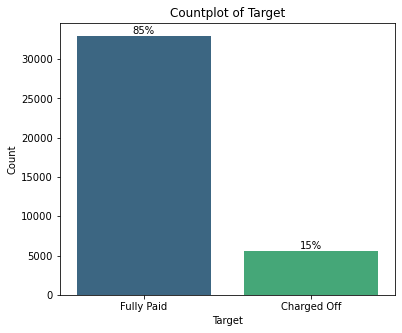

In [8]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=df, x='loan_status', palette='viridis')

total = len(df['target'])
for p in ax.patches:
    percentage = '{:.0f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Countplot of Target')
plt.show()

# Data Cleaning 

In [9]:
# Drop columns with no data
def get_null_rows_count():
   missing_df = pd.DataFrame(df.isnull().sum()/len(df)*100).reset_index()
   missing_df.columns = ['columns' , 'missing_percentage']
   missing_df= missing_df.sort_values('missing_percentage',ascending=False).reset_index(drop=True)
   return missing_df

missing_df = get_null_rows_count()
missing_df.head(5)

,columns,missing_percentage
0,mort_acc,100.0
1,mths_since_recent_bc_dlq,100.0
2,total_rev_hi_lim,100.0
3,mo_sin_rcnt_tl,100.0
4,mo_sin_rcnt_rev_tl_op,100.0


#### Get list of columns with 100 % null values and drop them from df


In [10]:
empty_columns = missing_df[missing_df['missing_percentage']==100]['columns'].to_list()

df.drop(columns = empty_columns , inplace=True)

missing_df = missing_df[(missing_df['missing_percentage']!=100)]

print(f'Number of columns remaining : {df.shape[1]}')

Number of columns remaining : 57


### Converting columns to appropriate data types

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          38577 non-null  int64  
 1   member_id                   38577 non-null  int64  
 2   loan_amnt                   38577 non-null  int64  
 3   funded_amnt                 38577 non-null  int64  
 4   funded_amnt_inv             38577 non-null  float64
 5   term                        38577 non-null  object 
 6   int_rate                    38577 non-null  object 
 7   installment                 38577 non-null  float64
 8   grade                       38577 non-null  object 
 9   sub_grade                   38577 non-null  object 
 10  emp_title                   36191 non-null  object 
 11  emp_length                  37544 non-null  object 
 12  home_ownership              38577 non-null  object 
 13  annual_inc                  385

In [12]:
df['term']

0         36 months
1         60 months
2         36 months
3         36 months
5         36 months
            ...    
39712     36 months
39713     36 months
39714     36 months
39715     36 months
39716     36 months
Name: term, Length: 38577, dtype: object

In [13]:
# convert to str to int
df['term'] = [str(i[:3]) for i in df['term']]
df['term'] = df['term'].astype('object')

In [14]:
df['int_rate']

0        10.65%
1        15.27%
2        15.96%
3        13.49%
5         7.90%
          ...  
39712     8.07%
39713    10.28%
39714     8.07%
39715     7.43%
39716    13.75%
Name: int_rate, Length: 38577, dtype: object

In [15]:
# convert to str to int
df['int_rate'] = df['int_rate'].str.replace('%','').astype('float')

In [16]:
df['emp_length'].value_counts(dropna=False)

10+ years    8488
< 1 year     4508
2 years      4291
3 years      4012
4 years      3342
5 years      3194
1 year       3169
6 years      2168
7 years      1711
8 years      1435
9 years      1226
NaN          1033
Name: emp_length, dtype: int64

In [17]:
# fill na with 0 years employment 
df['emp_length'] = df['emp_length'].fillna(0)

# convert employment length column from str to int 
df['emp_length'] = df['emp_length'].astype(str).apply(lambda x : int(re.sub(r'\D','',x)))

# convert emp_length to interval
df['emp_length'] = pd.qcut(df['emp_length'],q = 4, labels= ['0-2 years','2-4 years','4-8 years','8-10 years'])

df['emp_length'] = df['emp_length'].astype('object')

df['emp_length'].value_counts()

0-2 years     13001
4-8 years      9734
8-10 years     8488
2-4 years      7354
Name: emp_length, dtype: int64

In [18]:
# convert to str to int
df['revol_util'] = df['revol_util'].str.replace('%','').astype('float')
# binning revol_utilization
df['revol_util'] = pd.qcut(df['revol_util'],q=4,labels=['0-25%','25-50%','50-75%','75-100%'])
df['revol_util'] = df['revol_util'].astype('object')

In [19]:
# convert to str to date 

df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'],format='%b-%y')

df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'],format='%b-%y')

df['issue_d'] = pd.to_datetime(df['issue_d'],format='%b-%y')

df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'],format='%b-%y')

In [20]:
import datetime

today = pd.to_datetime(datetime.date.today())
df['mnths_since_earliest_cr_line'] = (today - df['earliest_cr_line'])/pd.Timedelta(days=1)
df['mnths_since_earliest_cr_line'] = df['mnths_since_earliest_cr_line'].apply(lambda x : int(round(x/30)))

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 58 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            38577 non-null  int64         
 1   member_id                     38577 non-null  int64         
 2   loan_amnt                     38577 non-null  int64         
 3   funded_amnt                   38577 non-null  int64         
 4   funded_amnt_inv               38577 non-null  float64       
 5   term                          38577 non-null  object        
 6   int_rate                      38577 non-null  float64       
 7   installment                   38577 non-null  float64       
 8   grade                         38577 non-null  object        
 9   sub_grade                     38577 non-null  object        
 10  emp_title                     36191 non-null  object        
 11  emp_length                  

### Dropping redundant columns 

In [22]:
# all these columns have just one unique value and it does not provide any insights 
redundant_cols =  [
                  'pymnt_plan',
                  'initial_list_status',
                  'application_type',
                  'policy_code',
                  'tax_liens',
                  'chargeoff_within_12_mths',
                  'delinq_amnt',
                  'collections_12_mths_ex_med',
                  'acc_now_delinq',
                  'out_prncp_inv',
                  'out_prncp'
                  ]

print('These column have only one unique value')
for i in redundant_cols:
   print(df[i].value_counts())
   print('========')

These column have only one unique value
n    38577
Name: pymnt_plan, dtype: int64
f    38577
Name: initial_list_status, dtype: int64
INDIVIDUAL    38577
Name: application_type, dtype: int64
1    38577
Name: policy_code, dtype: int64
0.0    38538
Name: tax_liens, dtype: int64
0.0    38521
Name: chargeoff_within_12_mths, dtype: int64
0    38577
Name: delinq_amnt, dtype: int64
0.0    38521
Name: collections_12_mths_ex_med, dtype: int64
0    38577
Name: acc_now_delinq, dtype: int64
0.0    38577
Name: out_prncp_inv, dtype: int64
0.0    38577
Name: out_prncp, dtype: int64


In [23]:
# drop emp_title as it does not give relevant insights after aggregation  

df['emp_title'].value_counts()

US Army                                     131
Bank of America                             107
IBM                                          65
AT&T                                         57
Kaiser Permanente                            56
                                           ... 
amneal pharmaceuticals                        1
Net Equity Financial                          1
Kernersville Fire Department                  1
The Keith Corp. (empl by county, now Kei      1
Evergreen Center                              1
Name: emp_title, Length: 28027, dtype: int64

In [24]:
# drop url as it does not give any insights 

df['url'].value_counts()

https://lendingclub.com/browse/loanDetail.action?loan_id=1077501    1
https://lendingclub.com/browse/loanDetail.action?loan_id=562133     1
https://lendingclub.com/browse/loanDetail.action?loan_id=558545     1
https://lendingclub.com/browse/loanDetail.action?loan_id=562256     1
https://lendingclub.com/browse/loanDetail.action?loan_id=562224     1
                                                                   ..
https://lendingclub.com/browse/loanDetail.action?loan_id=774290     1
https://lendingclub.com/browse/loanDetail.action?loan_id=774295     1
https://lendingclub.com/browse/loanDetail.action?loan_id=772732     1
https://lendingclub.com/browse/loanDetail.action?loan_id=774265     1
https://lendingclub.com/browse/loanDetail.action?loan_id=87023      1
Name: url, Length: 38577, dtype: int64

In [25]:
# drop irrelevant columns 
drop_cols = [
             'pymnt_plan',
             'initial_list_status',
             'application_type',
             'policy_code',
             'tax_liens',
             'chargeoff_within_12_mths',
             'delinq_amnt',
             'collections_12_mths_ex_med',
             'acc_now_delinq',
             'url',
             'emp_title',
             'zip_code',
             'id',
             'member_id',
             'desc',
             'title',
             'last_credit_pull_d',
             'mths_since_last_record',
             'out_prncp_inv',
             'out_prncp'
             ]
df.drop(columns=drop_cols , inplace=True)

missing_df = missing_df[~missing_df['columns'].isin(drop_cols)].reset_index(drop=True)

## let's check how many columns have missing value now 

<AxesSubplot:xlabel='missing_percentage', ylabel='columns'>

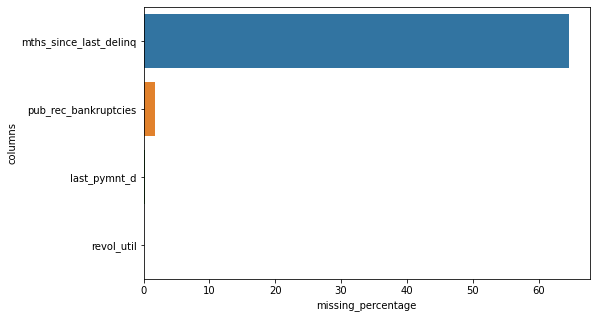

In [26]:
fig = plt.figure(figsize=(8,5))

missing_df = get_null_rows_count()

missing_df = missing_df[missing_df['missing_percentage']!=0]

sns.barplot(data=missing_df,y=missing_df['columns'],x=missing_df['missing_percentage'])

> since I am not sure if 'NaN' values in "months since deliquent" mean that they have not had any deliquency untill now or if that data is missing we'll drop this column as well

In [27]:
df['revol_util'] = df['revol_util'].fillna(0)

In [28]:
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(0)

In [29]:
df.drop(columns=['mths_since_last_delinq'],inplace=True)

# checking distribution of column values

In [30]:
df['disbursal_year'] = df['issue_d'].dt.year
df['disbursal_year'] = df['disbursal_year'].astype('object')

df['disbursal_month'] = df['issue_d'].dt.month
df['disbursal_month'] = df['disbursal_month'].astype('object')

In [31]:
numeric_cols = df.select_dtypes(include=['int','float']).columns.to_list()
categorical_cols = df.select_dtypes(include=['object']).columns.to_list()

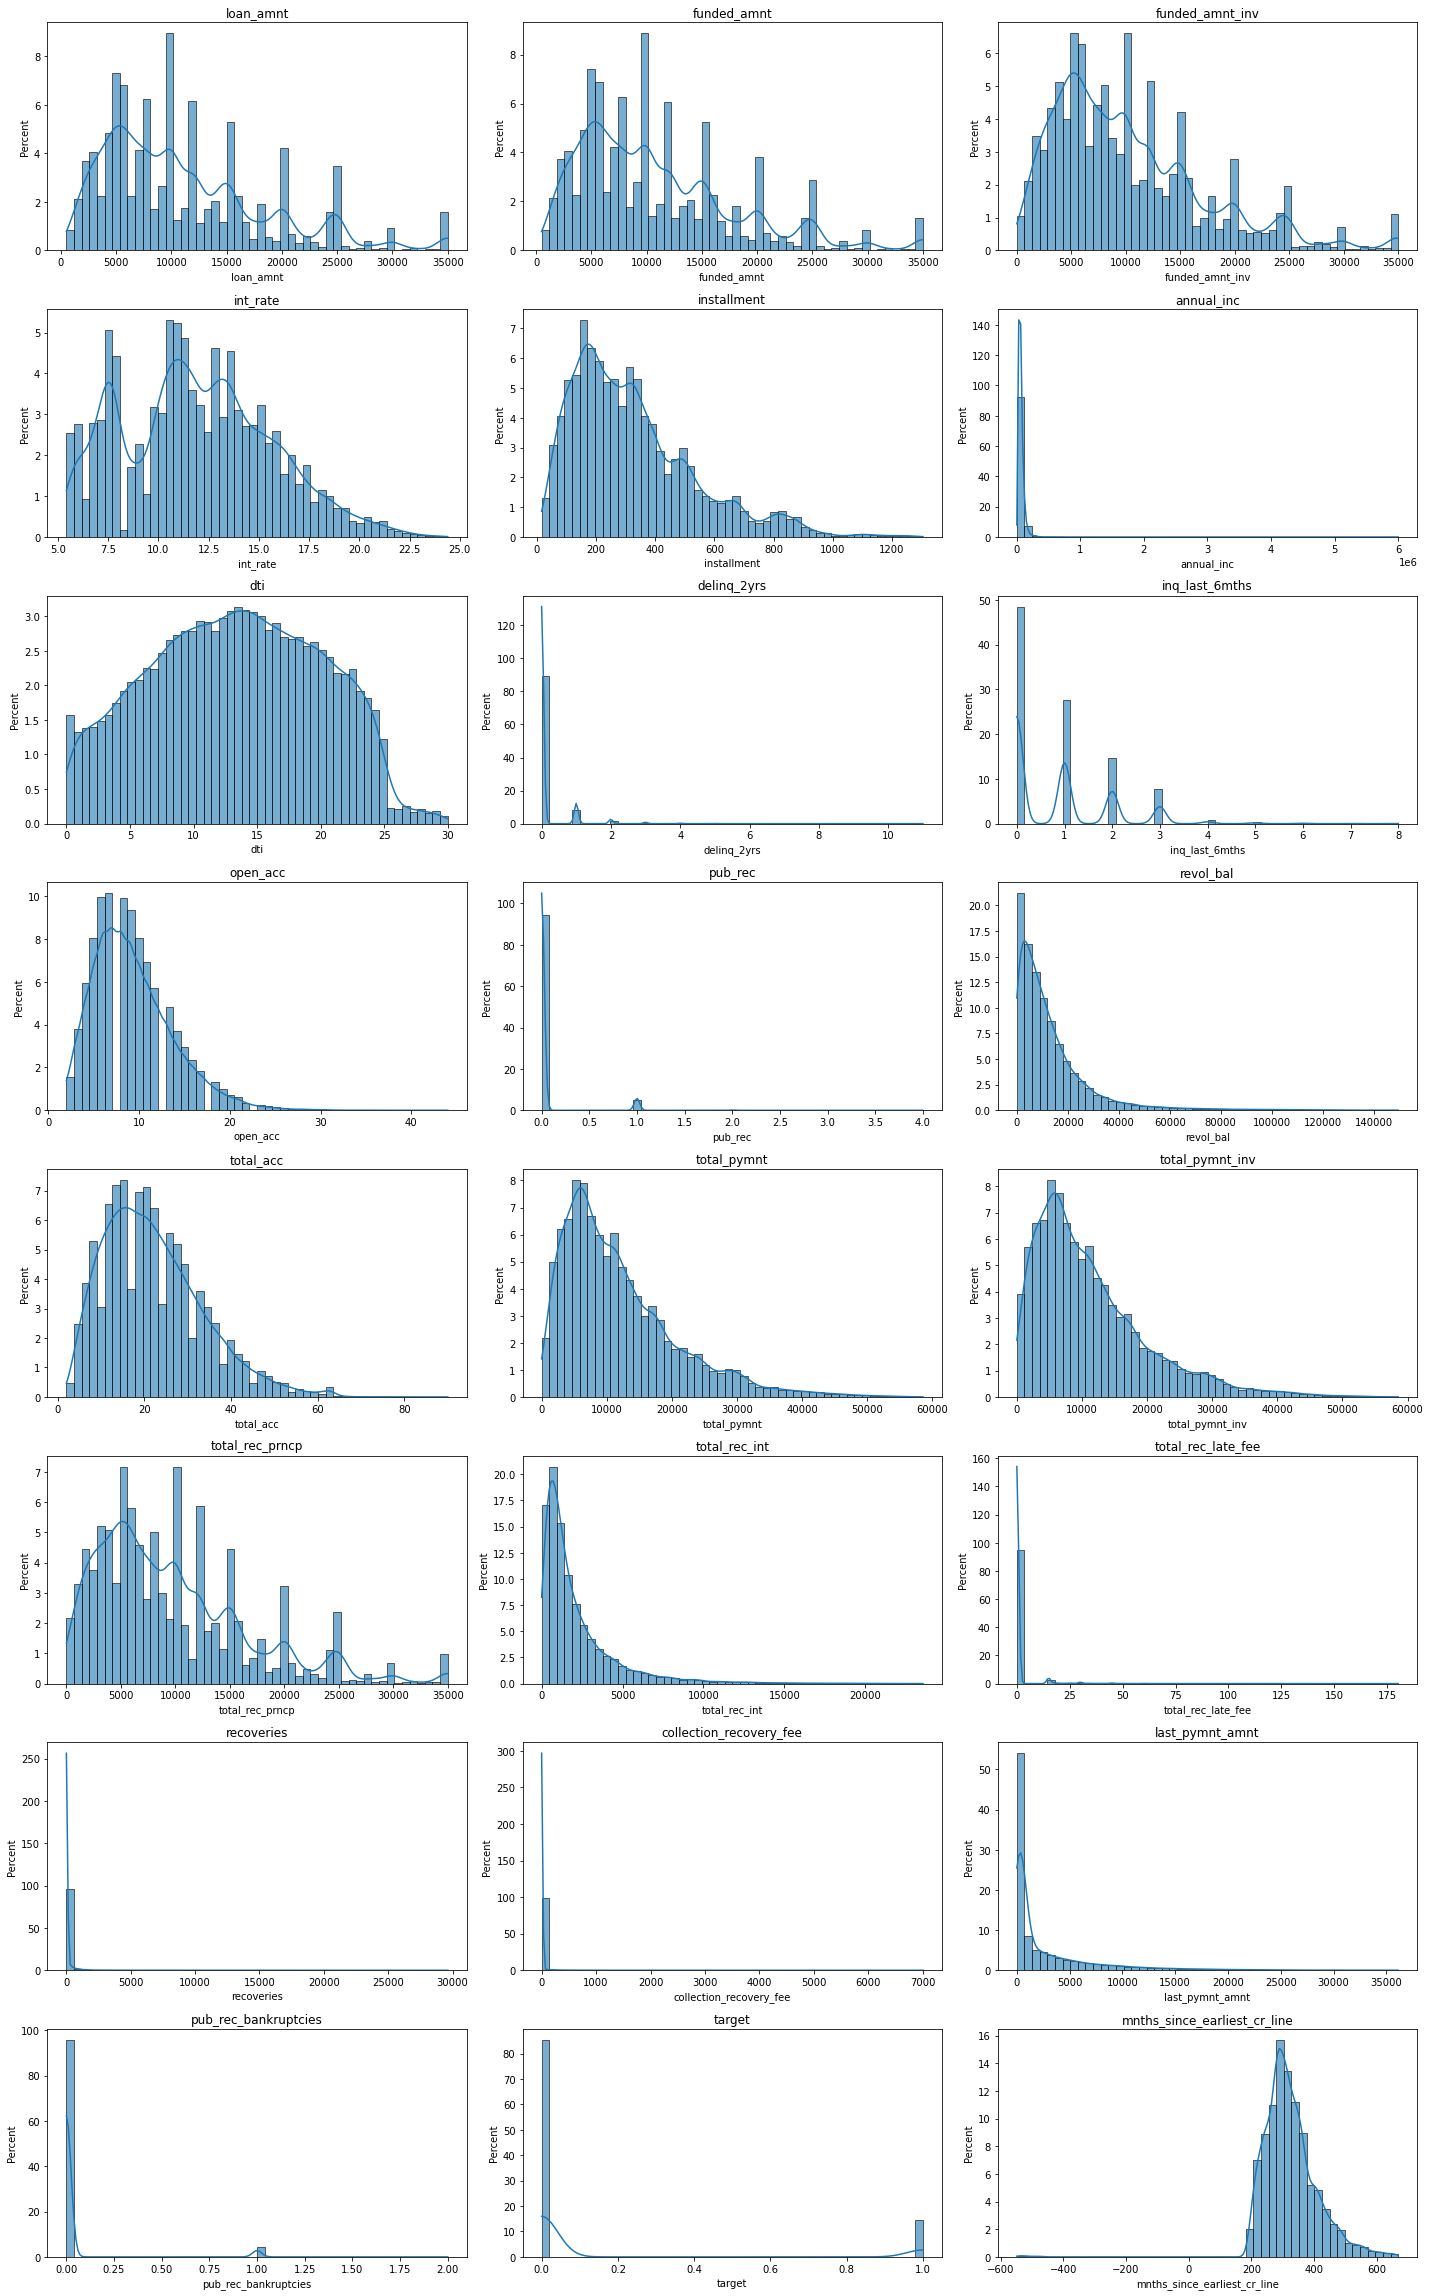

In [32]:
import math
n_bins = 50
palette = sns.color_palette("pastel") 

columns = df.select_dtypes(include=['int','float']).columns.to_list()
n_cols = 3
n_rows = math.ceil(len(columns) / n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
ax = ax.flatten()

for i, column in enumerate(columns):
   sns.histplot(
      df[column], kde=True, stat='percent', bins=n_bins,
      ax=ax[i], alpha=0.6
   )
   ax[i].set_title(column)

plt.tight_layout()
plt.show()

- from histogram we can see that outliers present in "annual_inc"
- we see that "mnths_since_earliest_cr_line" show negetive values , which is a data issue. We will drop these 85 rows
- majority loans are comming from 2011 and 2010  


In [33]:
df[df['mnths_since_earliest_cr_line']<0].head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,pub_rec_bankruptcies,target,mnths_since_earliest_cr_line,disbursal_year,disbursal_month
1576,21000,21000,20875.0,36,7.51,653.33,A,A3,0-2 years,MORTGAGE,49200.0,Verified,2011-12-01,Fully Paid,credit_card,MT,27.02,0,2062-09-01,1,8,0,14491,0-25%,15,23047.246210,22910.06,21000.00,2047.25,0.0,0.00,0.000,2013-09-01,10000.95,0.0,0,-472,2011,12
1764,5500,5500,5500.0,36,7.51,171.11,A,A3,2-4 years,RENT,63000.0,Verified,2011-12-01,Fully Paid,other,CA,5.56,2,2068-09-01,0,6,0,6981,0-25%,15,5538.320000,5538.32,5500.00,38.32,0.0,0.00,0.000,2012-02-01,539.21,0.0,0,-545,2011,12
3274,5000,5000,5000.0,36,12.69,167.73,B,B5,8-10 years,MORTGAGE,72000.0,Source Verified,2011-11-01,Fully Paid,vacation,PA,7.75,0,2067-09-01,1,5,0,4477,25-50%,25,6039.332116,6039.33,5000.00,1039.33,0.0,0.00,0.000,2014-12-01,187.76,0.0,0,-532,2011,11
3349,21000,21000,21000.0,36,12.69,704.45,B,B5,8-10 years,MORTGAGE,267000.0,Source Verified,2011-11-01,Fully Paid,small_business,CO,8.87,0,2065-02-01,2,10,0,51942,25-50%,27,25359.830010,25359.83,21000.00,4359.83,0.0,0.00,0.000,2014-12-01,725.56,0.0,0,-501,2011,11
3403,15000,15000,14900.0,60,16.77,370.94,D,D2,0-2 years,MORTGAGE,58000.0,Verified,2011-11-01,Charged Off,debt_consolidation,NH,22.08,0,2067-06-01,0,11,0,17700,75-100%,18,10248.670000,10180.30,2077.68,2370.40,0.0,5800.59,472.302,2012-12-01,29.88,0.0,1,-529,2011,11


In [34]:
df = df[df['mnths_since_earliest_cr_line']>0]

<AxesSubplot:xlabel='annual_inc'>

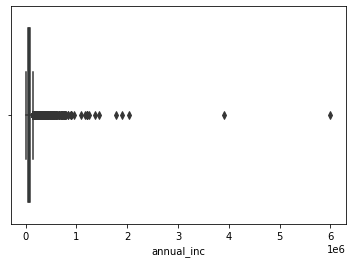

In [35]:
# annual income outliers
sns.boxplot(df['annual_inc'], palette='viridis')

In [36]:
outliers = round(np.percentile(df['annual_inc'],93))

print(f'remove annual income outliers after annual income : {outliers}')
# remove annual income skew from majority of population 
df = df[df['annual_inc']<outliers]


remove annual income outliers after annual income : 127000


<AxesSubplot:xlabel='annual_inc'>

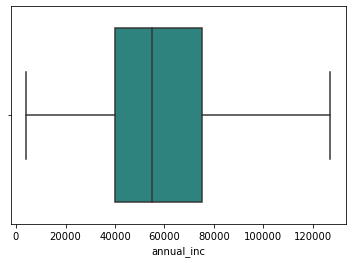

In [37]:
sns.boxplot(df['annual_inc'], palette='viridis')

# Bivariate analysis

In [38]:
def get_boxplot(col):
   plt.figure(figsize=(8,4))
   sns.boxplot(data=df,x= col,y='loan_status',palette='viridis')
   plt.show()

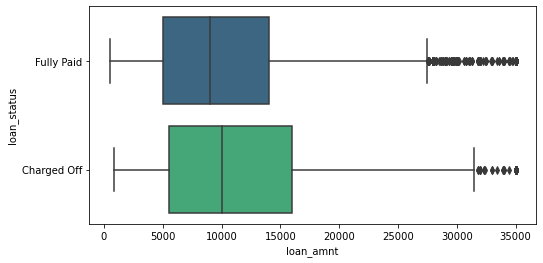

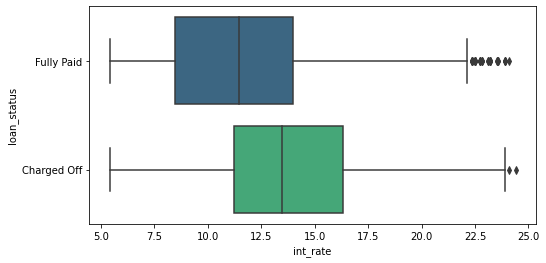

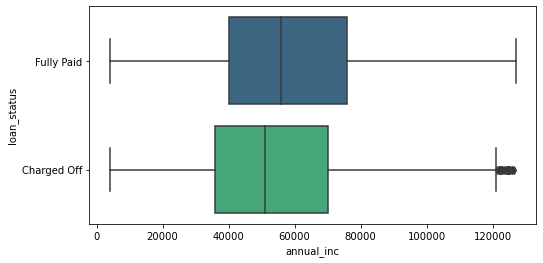

In [39]:
for i in ['loan_amnt',
         'int_rate',
         'annual_inc'] : 
   get_boxplot(i)

- loan amount given to charged off cases was slightly higher than fully paid. 
- interest rate was higher for charged off cases. 
- I can also notice that annual income of charged off cases is slightly lower than fully paid
 

### convert numerical columns to --> categorical columns by binning to extract trends

In [40]:
# converting to categorical variable 
df.loc[df['pub_rec'].isna(),'pub_rec'] = 0

df['pub_rec'] = df['pub_rec'].astype('object')

In [41]:
# converting to categorical variable 
df.loc[df['pub_rec_bankruptcies'].isna(),'pub_rec_bankruptcies'] = 0

df.loc[df['pub_rec_bankruptcies']>0, 'pub_rec_bankruptcies'] = 1

df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].astype('object')

### Binning - 
-   emi amount column
-   debt to income (dti) column
-   loan amount
-   revolving balance 
-   annual income
- interest rate
- inquiry last 6 months

In [42]:
# function for binning the column

def bin_the_column(col,q=4):
   df[col] = pd.qcut(df[col],q=4,duplicates='drop')
   df[col] = df[col].astype('object')

In [43]:

for col in ['installment',
            'dti',
            'loan_amnt',
            'revol_bal',
            'annual_inc',
            'mnths_since_earliest_cr_line',
            'open_acc',
            'total_acc',
            'inq_last_6mths',
            'int_rate']:
   bin_the_column(col)
   

In [44]:
df['last_pymnt_d'] = (pd.to_datetime(today,format='%Y-%m-%d') - df['last_pymnt_d'])/30
df['last_pymnt_d'] = df['last_pymnt_d']/pd.Timedelta(days=1)
df['last_pymnt_d'] = round(df['last_pymnt_d'])

### StateWise default rate 

In [45]:
df_defaults = df[df['target'] == 0]

state_defaults = df_defaults.groupby('addr_state').size().reset_index(name='count')

# pie chart
fig = px.pie(state_defaults, values='count', names='addr_state', hole=0.3)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title='Total Defaults % by state', showlegend=False, plot_bgcolor='rgba(240,240,240,1)')
fig.show()


### this does not give a clear picture about defaults, may be CA state has disbursed more loans and as a result has more defaults. We need percentage of defaults for loans disbursed

# Countplot against target

In [46]:
def get_annot_countplot(col,palette = {1: 'red', 0: 'lightgreen'},figsize=(30, 6) ):
   plt.figure(figsize=figsize)

   grouped = df.groupby(col)['target'].value_counts(normalize=True).unstack().fillna(0) * 100

   order = grouped.sort_values(by=1, ascending=False).index

   sns.countplot(
         data=df, x=col, order=order,
         alpha=0.6, hue='target', palette=palette
      )

   # annotate with %
   for idx, cat in enumerate(order):
      ones_percent = grouped.loc[cat, 1] if 1 in grouped.columns else 0 # for perc of 1
      zeros_percent = grouped.loc[cat, 0] if 0 in grouped.columns else 0 

      plt.text(
            idx, grouped.loc[cat].max(), f"1: {ones_percent:.0f}%\n0: {zeros_percent:.0f}%",
            ha='center', fontsize=10, color='black'
      )
   plt.xticks(fontsize=12)
   plt.title(f'Countplot of {col} against Target')
   plt.xlabel(col,fontsize = 14)
   plt.ylabel('Count')
   plt.tight_layout()
   plt.show()

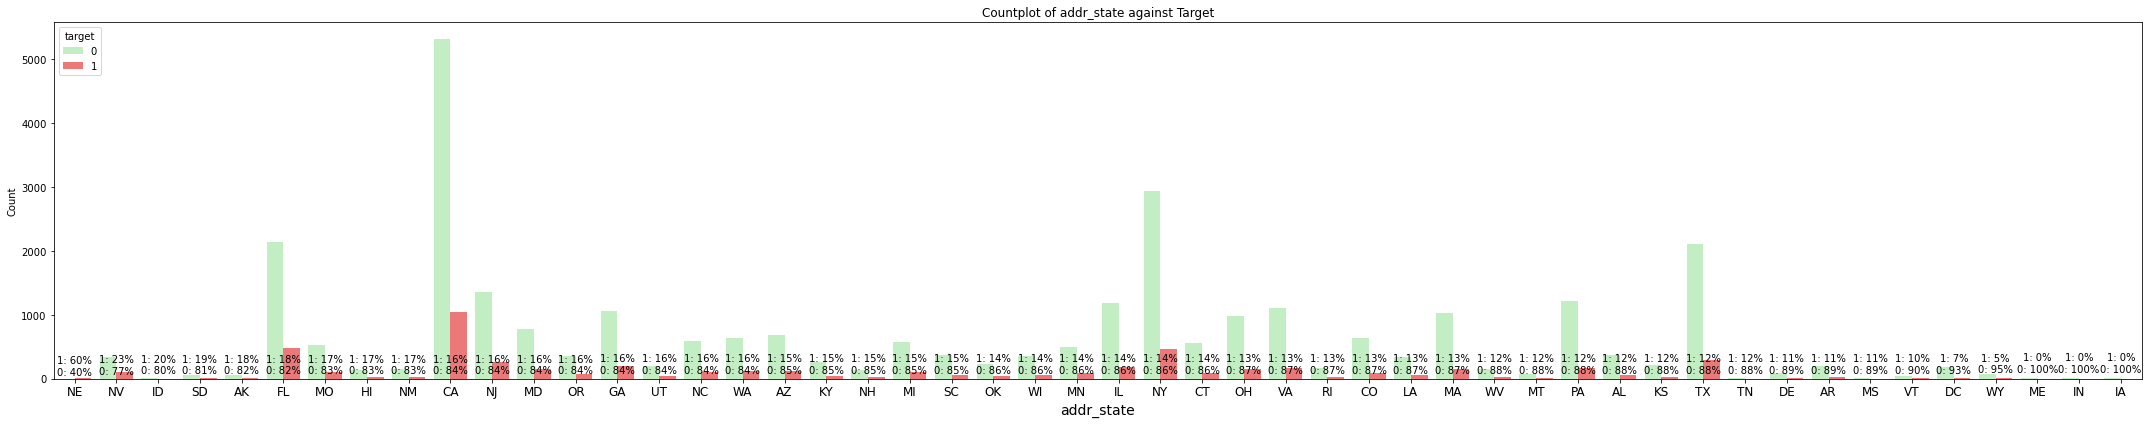

In [47]:
get_annot_countplot(col='addr_state')

### It is clear from above countplot that "addr_state" column we see that NE has 60 % default rates. This could be pointing to possibility of fraud cases. Also states like NV, ID, SD and and AK have high default rates.

In [48]:
categorical_cols

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'loan_status',
 'purpose',
 'addr_state',
 'revol_util',
 'disbursal_year',
 'disbursal_month']

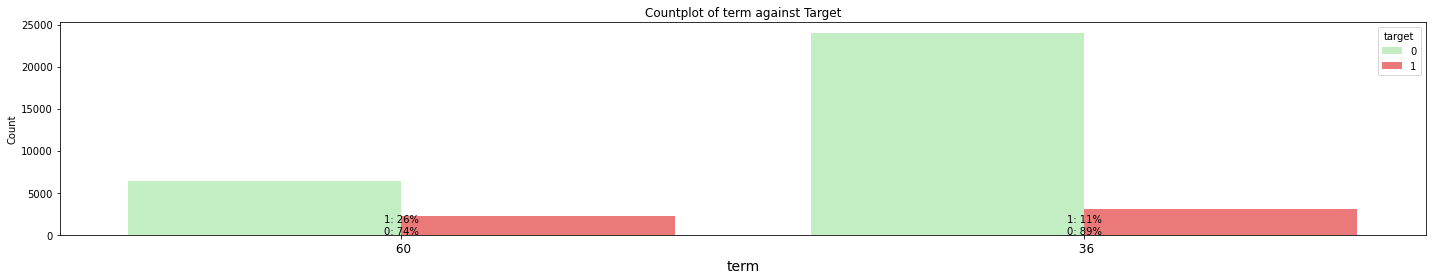

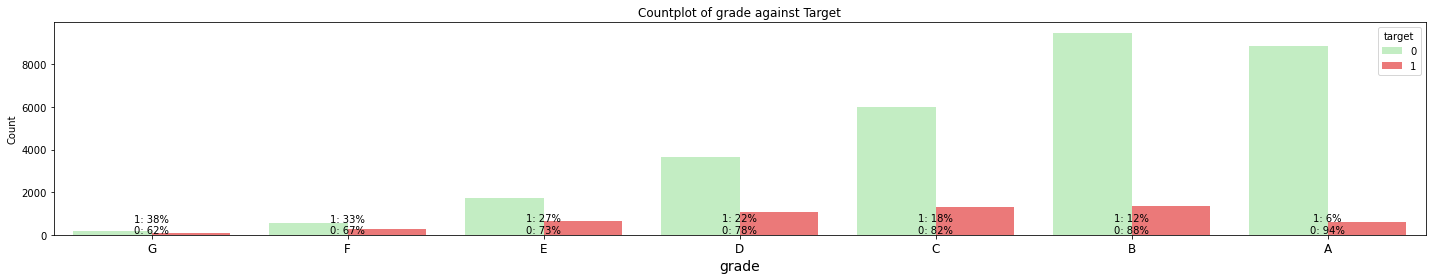

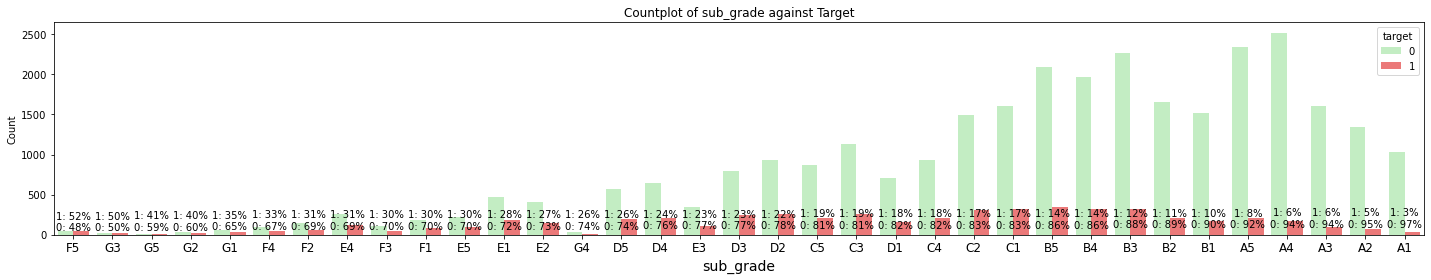

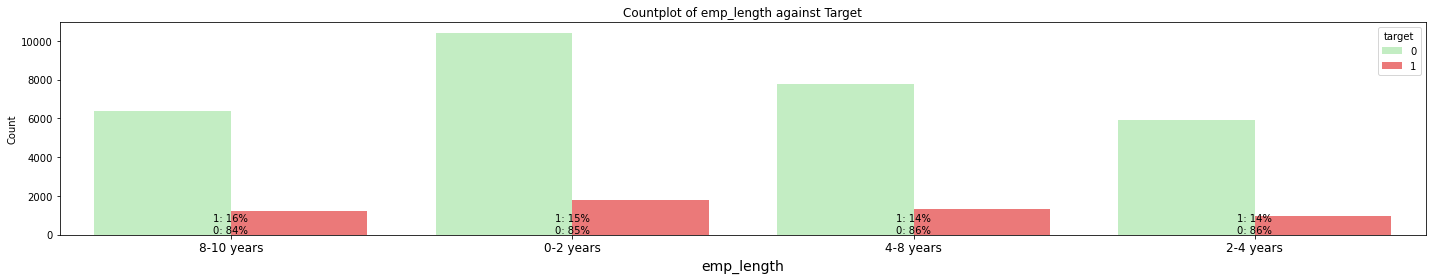

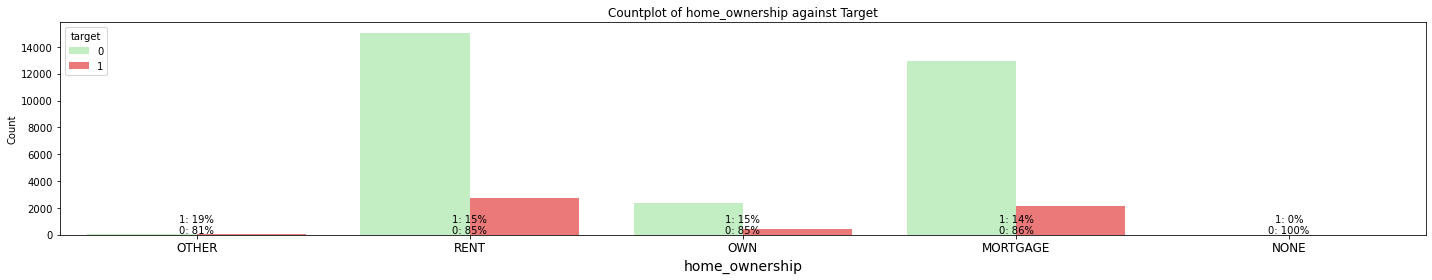

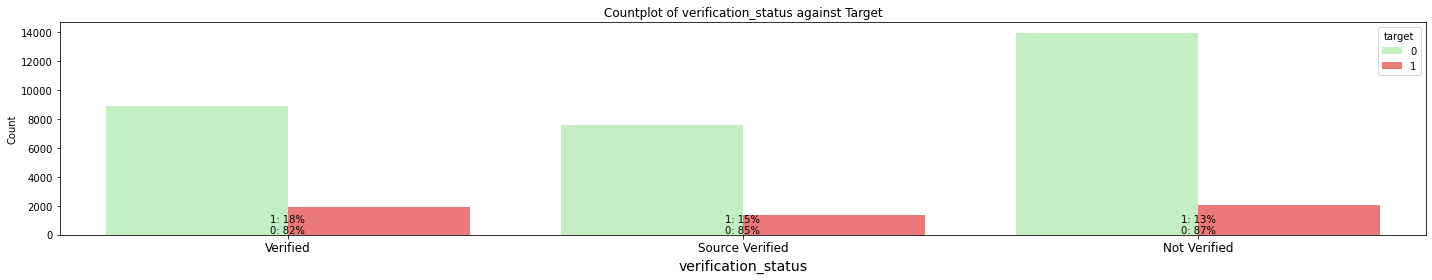

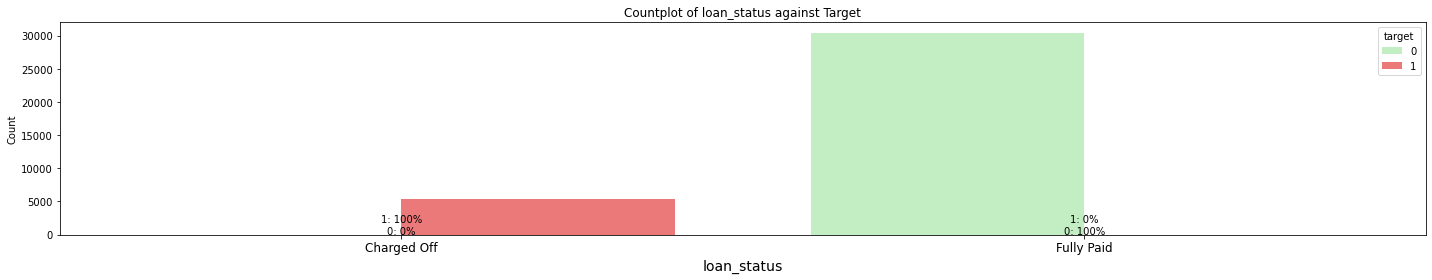

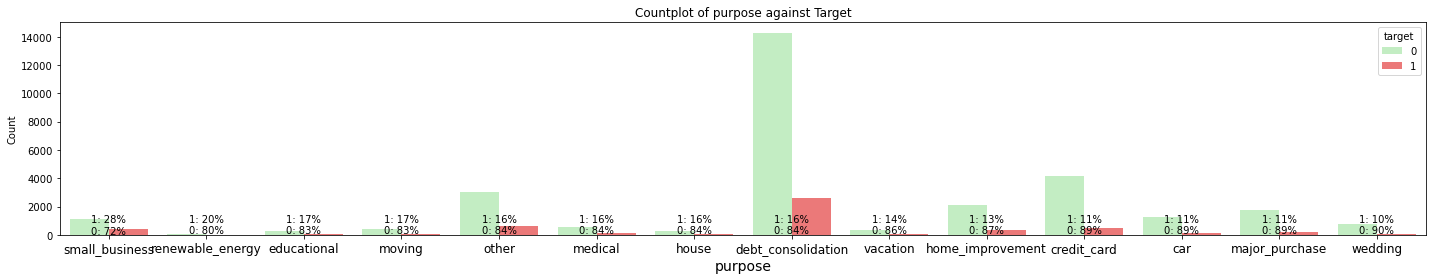

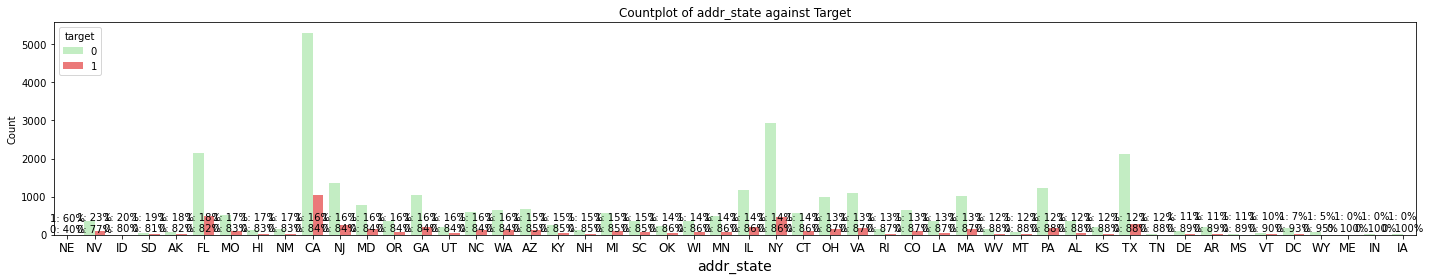

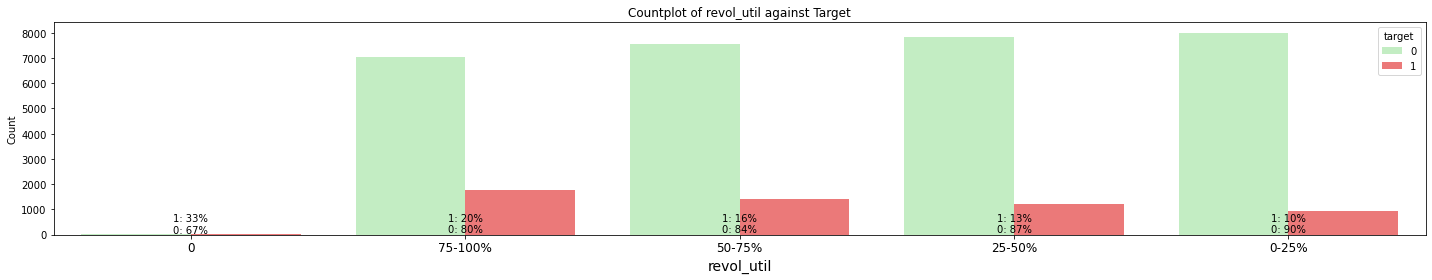

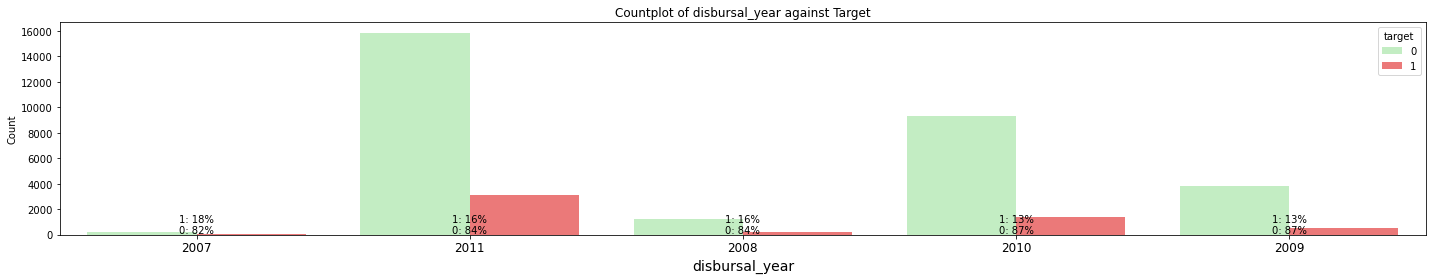

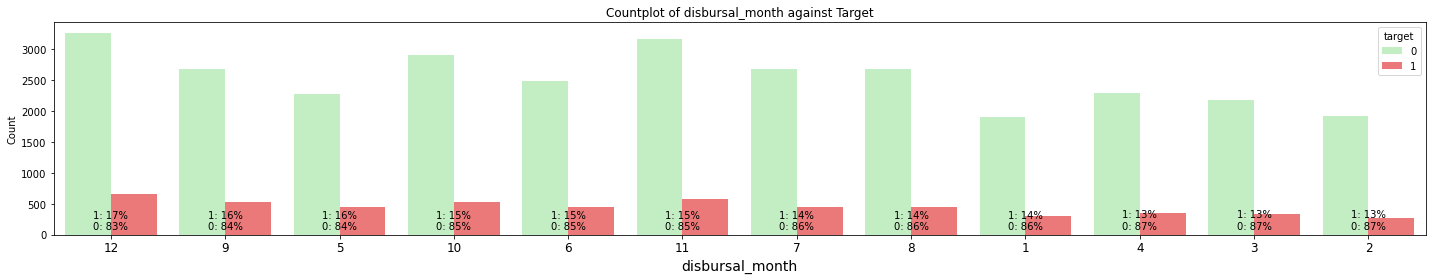

In [49]:
# percentage of default in each category for each column
for column in categorical_cols:
   get_annot_countplot(column, figsize=(20,4))
    


#### OBSERVATIONS

- In "Grade" column (G,F,E) categories are the worst as more than 25 % users in these categories have defaulted. Similar trends are followed in "sub_grade" column where sub grades of (G,F,E) have high default rates.We see that as "Grade" decreases deafaults increase , hence this column is good indicator of whether user will default on a loan
- in "purpose" column we see that "small business" category has highest default rates , followed by renewable energy. One can increase interest rates to mitigate risk.   
- "home ownership" does not show any significant lift in categories. 
- "verification_status" column does not show any lift in categories. Default rates are more or less the same across category
- "emp_length" does not give any lift
- "revol_util" higher utilization of credit indicates higher default rate
- lower "annual_inc" points to higher default rate
- higher debt to income ratio , higher default rates
- people who have public bankruptcies have higher default rates
